#    Prediction of Remaining Useful Life (RUL) of turbofan engine
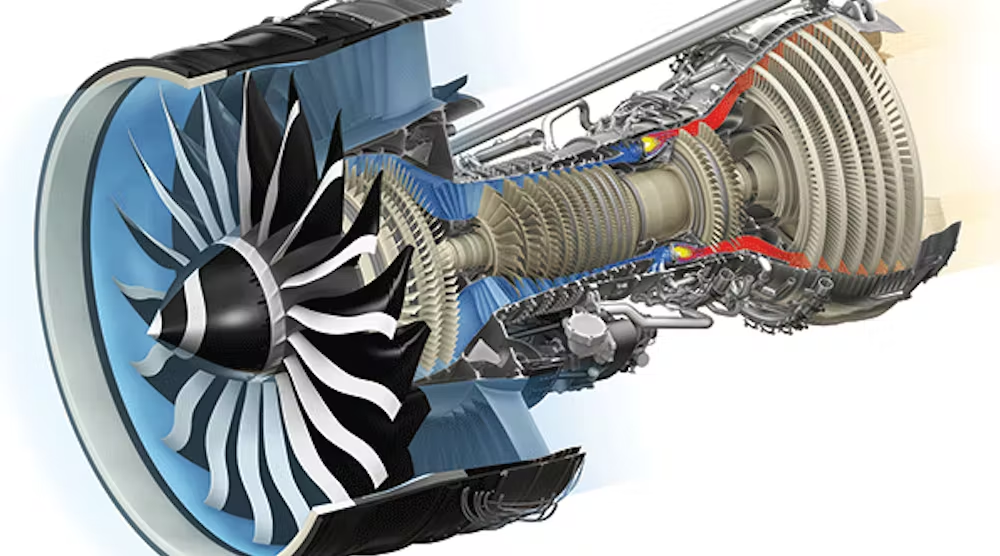

This capstone project will demonstrate how machine learning (ML) can be used to predict the Remaining Useful Life (RUL) of turbofan engines. The main objective of this project is to develop an ML predictive model that can predict how many time steps remain until the engine fails based on sensor information describing the engine's present and past performance.  By using the proposed ML model, an engine operator could direct maintenance toward engines at risk of failure, which will improve the maintenance routine's efficiency and, most importantly, increases reliability.







 importing the required libraries

In [1]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("Scikit-learn version: ", sklearn.__version__)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Pandas version:  1.5.1
Numpy version:  1.23.4
Scikit-learn version:  1.1.3


In [2]:

# Identify column names to make indexing easier

index_name=["unit_number","cycles"]
operational_setting =["setting_1","setting_2","setting_3"]
sensor=["s_{}".format(i+1) for i in range(0,21)]

col_names = index_name + operational_setting + sensor

# read data

train = pd.read_csv(r"/mnt/c/Users/safsa/Desktop/Fourth_Brain/MLE_project/Project/data/train_FD001.txt", sep = "\s+", header = None,index_col=False,names=col_names)

test = pd.read_csv(r"/mnt/c/Users/safsa/Desktop/Fourth_Brain/MLE_project/Project/data/test_FD001.txt", sep = "\s+", header = None,index_col=False,names=col_names)

y_test = pd.read_csv(r"/mnt/c/Users/safsa/Desktop/Fourth_Brain/MLE_project/Project/data/RUL_FD001.txt", sep = "\s+", header = None,names=['RUL'])








To verify that the data was imported correctly and for a general overview of the data set, a basic diagnostic analysis is preformed :

In [6]:

train.shape

(20631, 26)

In [7]:
train.head()

,unit_number,cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_number  20631 non-null  int64  
 1   cycles       20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

## Calculating the RUL 

Calculating RUL is important because it serves two important purposes: 


1. When plotting sensor signals, it will be  used as an X-axis variable to enable easy interpretation of changes in the sensor signals as the engines approach failure.

2. It is the target variable in supervised machine learning 

Since we do not have any information about engines' RUL in the training set, we must make our own estimates. Our assumption is that the RUL decreases linearly over time and reaches 0 at the end of the engine's lifecycle. According to this assumption, RUL at 10 cycles just before breakdown would be 10, and 50 at 50 cycles just before breakdown, etc

The  RUL can be calculated mathematically using max_cycle - cycles. The dataframe will be grouped by unit_number before computing max__cycle in order to account for the max_cycle of each engine. To make the calculation of the RUL easier, max_ cycle is merged back into the dataframe, and the RUL is calculated by subtracting cycles from max_cycle  (max_cycle — cycles). Max_cycle is then dropped since it is no longer needed


In [12]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_name+['RUL']].head()

,unit_number,cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


From the histogram, we can conclude that most engines break down around 200 cycles which coincides  with the result that was obtained form the descriptive statistics

# Baseline ML 

To prepare the data for modeling, I  will remove the unit_number, cycle, settings, and some of the sensor columns that do not contain useful information. The RUL column in the training set will be stored in a separate variable. For the test set, I will also drop these irrelevant columns.  This preprocessed data will be used to train and evaluate our model for predicting the RUL of turbofan engines.

In [23]:
#Deropping uncceary sanasor 
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_name + operational_setting+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_1=pd.DataFrame(y_train) 

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

To assess the performance of the  models, an evaluation function that calculates the Root Mean Squared Error (RMSE) and the Explained Variance (or R² score) is defiened . The RMSE will measure the average difference between the predicted and actual values of the RUL, while the R² score will indicate how well the model can explain the variations in the RUL using the input features. These metrics will help in  evaluateing  the quality of the predictions and  to compare different models.

In [19]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [20]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_1, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)


train set RMSE:44.66819159545419, R2:0.579448652779678
test set RMSE:31.952633027740525, R2:0.4087736807657887


you can see that the test set  RMSE is less than the train set RMSE  which does not make seen since usaly the  model do better  for the data that has seen berfor . one explination to this is that there a problem with the  calulcated RUL  in EDA Section 

# lazy predict: 
lazy predict is used to helps understand which models work better 

In [24]:
import lazypredict

In [22]:
from lazypredict.Supervised import LazyRegressor

X_train_1 = X_train.sample(2000,random_state=3,replace=True)
X_test_1 = X_test.sample(2000,random_state=3,replace=True)
y_train_3 = y_train_1.sample(2000,random_state=3,replace=True)
y_test_1 = y_test.sample(2000,random_state=3,replace=True)

reg = LazyRegressor()
models, predictions = reg.fit(X_train_1, X_test_1, y_train_3, y_test_1)

print(models)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [02:08<00:00,  3.06s/it]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
SVR                                          0.70       0.70 23.02        0.39
PassiveAggressiveRegressor                   0.66       0.66 24.60        0.02
LinearSVR                                    0.64       0.64 25.13        0.01
NuSVR                                        0.58       0.58 27.27        0.23
HuberRegressor                               0.56       0.57 27.76        0.06
TweedieRegressor                             0.48       0.48 30.38        0.01
ElasticNet                                   0.47       0.48 30.52        0.01
GradientBoostingRegressor                    0.47       0.47 30.56        0.49
ElasticNetCV                                 0.46       0.47 30.84        0.06
BayesianRidge                                0.45       0.46 31.09        0.05
Lasso                                        0.45   

In [25]:
models


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR,0.70,0.70,23.02,0.39
PassiveAggressiveRegressor,0.66,0.66,24.60,0.02
LinearSVR,0.64,0.64,25.13,0.01
NuSVR,0.58,0.58,27.27,0.23
HuberRegressor,0.56,0.57,27.76,0.06
TweedieRegressor,0.48,0.48,30.38,0.01
ElasticNet,0.47,0.48,30.52,0.01
GradientBoostingRegressor,0.47,0.47,30.56,0.49
ElasticNetCV,0.46,0.47,30.84,0.06


It can be observed from the result of the  lazy predict that the support vector regression (SVR ) gives the best result.In addition, the result of the linear  regression  is  similar  to the result that was optioned earlier  


# What next : 

Next, I will attempt to address the issue of the test set RMSE being lower than the train set RMS by exploring different methods of calculating the RUL for the training set. This may help improve the accuracy of the model and bring the RMSE of the train and test sets closer together.